## plotting figures and some stats for the neanderthal predixcan manuscript

<a id='Contents'></a>
### Contents

- [Filtering Gene Sets](#filter)
- [DR Gene Counts](#drcounts)
- [Phenotype Counts](#phenocounts)
- [GO Term Plot](#goplot)
- [DR GWARR Plot](#gwarrplot)
- [Desert Gene Plot](#desertplot)
- [1kG Distribution Plots](#1kgdist)
- [Direction Bias](#bias)
- [Neanderthal Correlations](#neancorr)
- [Tissue/DR Gene Correlation](#tisscorr)


#### load libraries, standard info

In [1]:
library(readr)
library(dplyr)
library(ggplot2)
library(fmsb)
library(PheWAS)
library(karyoploteR)
library(knitr)

abbreviations <- c("ADPS","ESPMC","ABPV","ESPMS","ADRNLG","HRTAA","BRNACC","HRTLV","ARTA","LIVER","ARTC","LUNG","ARTT","MSCSK","BRNCDT","NERVET","BRNCHB","OVARY",
                   "BRNCHA","PNCS","BRNCTX","PTTY","BRNFCTX","PRSTT","BRNHPP","SKINNS","BRNHPT","SKINS","BRNNCC","SMINT","BRNPTM","SPLEEN","BREAST","STMCH","TESTIS",
                   "FIBS","THYROID","CLNS","UTERUS","CLNT","VAGINA","ESPGJ","WHLBLD")
names(abbreviations) <- c("adipose_subcutaneous","esophagus_mucosa","adipose_visceral_omentum","esophagus_muscularis",
        "adrenal_gland","heart_atrial_appendage","anterior_cingulate_cortex","left_ventricle","artery_aorta","liver","artery_coronary",
        "lung","artery_tibial","muscle_skeletal","brain_caudate_basal_ganglia","nerve_tibial","brain_cerebellar_hemisphere","ovary",                                
        "brain_cerebellum","pancreas","brain_cortex","pituitary","brain_frontal_cortex","prostate","brain_hippocampus","skin_nosun_suprapubic","brain_hypothalamus",
        "skin_sun_lower_leg","brain_nucleus_accumbens_basal_ganglia","small_intestine_terminal_ileum","brain_putamen_basal_ganglia",
        "spleen","breast_mammary_tissue","stomach","testis","cells_transformed_fibroblasts","thyroid","colon_sigmoid","uterus",
        "colon_transverse","vagina","esophagus_gastroesophageal_junction","whole_blood")



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: tidyr
Loading required package: parallel


<a id='filter'></a>
### Filtering for all non-DR, non-intro genes

In [ ]:
desert_file <- "../data/altai_desert_genes.txt"
intro_file <- "../data/altai_intro_genes.txt"
all_file <- "../../../altai_temp/altai_1kG_fixed_p_values_2sided_tissues_top_genes.txt"
excl_file <- "../data/altai_original_missingModels.txt"

excl_genes <- read_delim(excl_file,"\t", escape_double = FALSE, col_names = FALSE, trim_ws = TRUE)
desert_genes <- read_delim(desert_file,"\t", escape_double = FALSE, col_names = FALSE, trim_ws = TRUE)
intro_genes <- read_delim(intro_file,"\t", escape_double = FALSE, col_names = FALSE, trim_ws = TRUE)
all_genes <- read_delim(all_file,"\t", escape_double = FALSE, col_names = FALSE, trim_ws = TRUE)

all_genes$X1 <- all_genes$X3
all_genes$X2 <- NULL
all_genes$X3 <- NULL
all_genes <- unique(all_genes)

In [ ]:
desert_genes <- inner_join(anti_join(anti_join(desert_genes,intro_genes),excl_genes),all_genes)
drgwarrs <- anti_join(all_genes,anti_join(intro_genes,excl_genes))
drintro <- inner_join(all_genes,anti_join(intro_genes,excl_genes))

write.table(desert_genes,"../../../dr_desert_genes_LDexpand.txt",quote=F, col.names=F,row.names=F,sep="\t")
write.table(drgwarrs,"../../../dr_gwarrs_LDexpand.txt",quote=F, col.names=F,row.names=F,sep="\t")
write.table(drintro,"../../../dr_intro_LDexpand.txt",quote=F, col.names=F,row.names=F,sep="\t")

***
[Contents](#Contents)

<a id='drcounts'></a>
#### plot counts of DR genes per tissue, filtered for Non-Introgressed genes

Parsed with column specification:
cols(
  .default = col_double(),
  gene_id = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  X1 = col_character()
)
Joining, by = "gene_id"


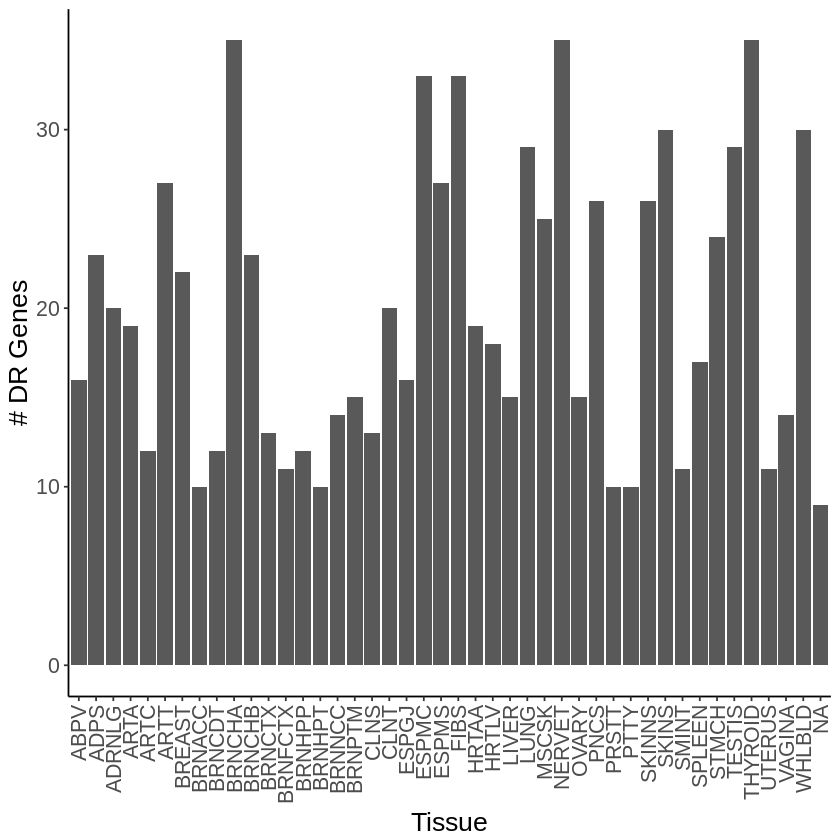

In [8]:
p_file_path <- "../data/altai_original_pvalues_2sided.txt"
intro_path <- "../data/altai_intro_genes.txt"

p_mat <- read_delim(p_file_path, "\t", escape_double = FALSE, trim_ws = TRUE)
intro <- read_csv(intro_path, col_names = FALSE)
intro$gene_id <- intro$X1
intro$X1 <- NULL
p_mat <- anti_join(p_mat, intro)
counts <- c()
tiss <- c()
for (i in 2:ncol(p_mat)) {
tiss <- c(tiss, names(p_mat[i]))
counts <- c(counts,nrow(p_mat[!is.na(p_mat[,i]) & p_mat[,i] == 0,]))
}
out <- data.frame(num = counts, Tissue = tiss)
for (i in 1:nrow(out)) {
out$abb[i] <- abbreviations[as.character(out$Tissue[i])]
}
ggplot(out, aes(x = abb, y = num)) + geom_bar(stat="identity") + labs(x="Tissue",y="# DR Genes") + 
theme_classic() + theme(text = element_text(size=16), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
ggsave('dr_gene_counts.pdf', width=7, height= 5) 

***
[Contents](#Contents)

<a id='phenocounts'></a>
#### groups phenotypes and counts associations per group

Parsed with column specification:
cols(
  tissue = col_character(),
  phecode = col_character(),
  beta = col_double(),
  `p-value` = col_double(),
  gene = col_character(),
  trait = col_character(),
  r2 = col_double(),
  OR = col_double(),
  `no of cases` = col_integer(),
  `no of controls` = col_integer()
)
Parsed with column specification:
cols(
  `#names` = col_character()
)
Joining, by = "gene"


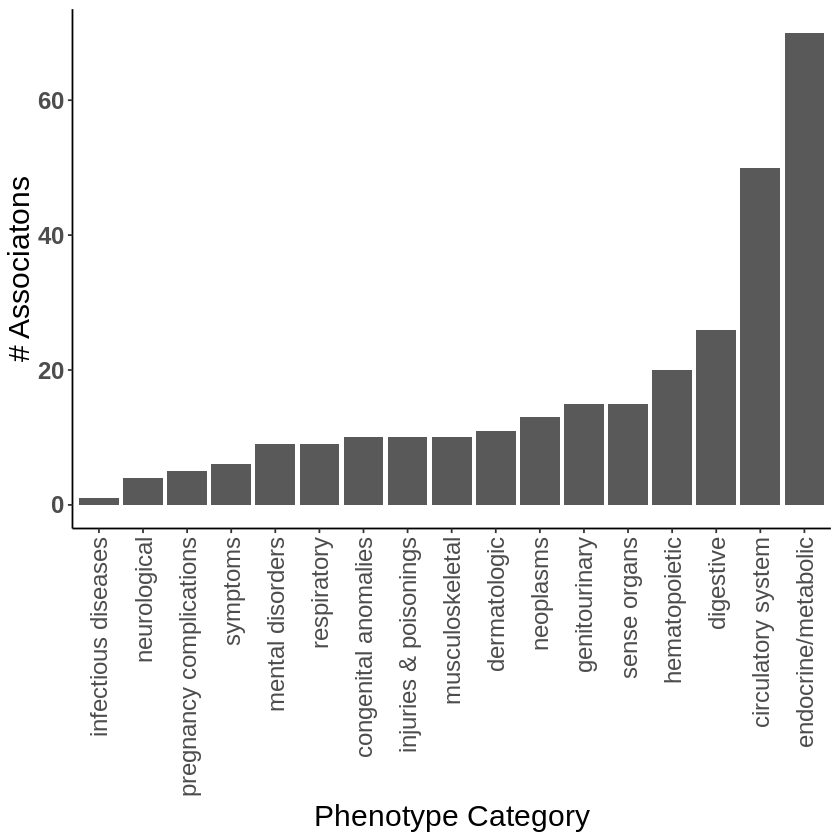

In [9]:
top_genes <- "../data/altai_dr_phewas.txt"
full_assoc_nean <- read_delim(top_genes, "\t", escape_double = FALSE, trim_ws = TRUE)
data(pheinfo)
full_assoc_nean$group <- "none"
full_assoc_nean <- full_assoc_nean[((full_assoc_nean$`p-value` < 0.00001) & (full_assoc_nean$`no of cases` > 30)),]

## if filtering by introgression status of genes:
intro_genes <- read_csv("../data/altai_intro_genes_names.txt")
intro_genes$gene <- intro_genes$`#names`
intro_genes$`#names` <- NULL

# get introgressed genes
#full_assoc_nean <- inner_join(full_assoc_nean, intro_genes)

# get non-Introgressed genes
full_assoc_nean <- anti_join(full_assoc_nean, intro_genes)

for (row in 1:nrow(pheinfo)) {
    phecode <- pheinfo$phecode[row]
    if (startsWith(phecode, "00")) {phecode <- substr(phecode,3,nchar(phecode))}
    if (startsWith(phecode, "0")) {phecode <- substr(phecode,2,nchar(phecode))}
    if (paste("X",phecode,sep="") %in% full_assoc_nean$phecode) {
      full_assoc_nean[full_assoc_nean$phecode == paste("X",phecode,sep=""),]$group <- pheinfo$group[row]
    }
}
full_assoc_nean$sum <- 1
counts <- full_assoc_nean %>% group_by(group) %>% summarise(sum = sum(sum))
counts$t_sum <- 0
for (row in 1:nrow(counts)) {
    counts$t_sum[row] <- nrow(pheinfo[pheinfo$group == counts$group[row],])
}
counts$prop <- counts$sum/counts$t_sum
ggplot(counts,aes(x=reorder(group,sum),y=sum)) + ylab("# Associatons") + xlab("Phenotype Category") + theme_classic() + 
theme(legend.position = "none",text = element_text(size=18),axis.text.x = element_text(angle = 90,vjust=0.5,
           hjust=1),axis.text.y = element_text(face = "bold")) + geom_bar(stat="identity")
#ggsave('../phewas_counts.pdf', width=6, height= 6) 

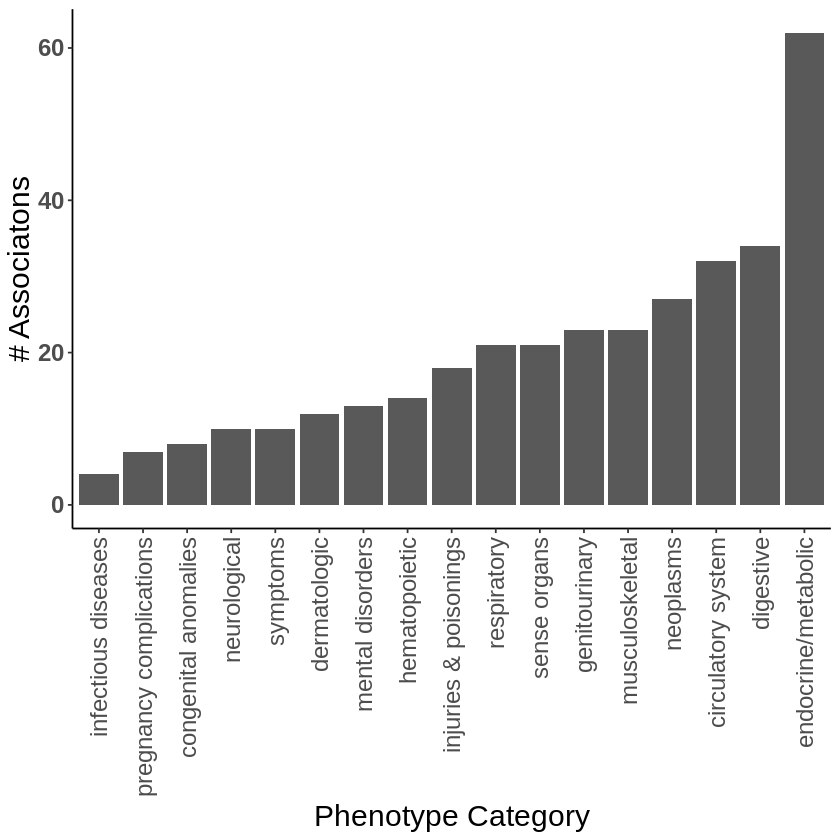

In [8]:
#run after previous cell, adding filtering out tissues
filt_nean <- full_assoc_nean %>% group_by(phecode,gene,trait,group,sum) %>% summarize(pvalue=min(`p-value`))
counts <- filt_nean %>% group_by(group) %>% summarise(sum = sum(sum))
counts$t_sum <- 0
for (row in 1:nrow(counts)) {
    counts$t_sum[row] <- nrow(pheinfo[pheinfo$group == counts$group[row],])
}
counts$prop <- counts$sum/counts$t_sum
ggplot(counts,aes(x=reorder(group,sum),y=sum)) + ylab("# Associatons") + xlab("Phenotype Category") + theme_classic() + 
theme(legend.position = "none",text = element_text(size=18),axis.text.x = element_text(angle = 90,vjust=0.5,
           hjust=1),axis.text.y = element_text(face = "bold")) + geom_bar(stat="identity")
ggsave('../phewas_counts_uniqueAssoc.pdf', width=6, height= 6) 

***
[Contents](#Contents)

<a id='goplot'></a>
#### Plot GO associations

Parsed with column specification:
cols(
  geneset = col_character(),
  description = col_character(),
  link = col_character(),
  C = col_integer(),
  O = col_integer(),
  E = col_double(),
  R = col_double(),
  PValue = col_double(),
  FDR = col_double(),
  overlapGene = col_character(),
  OverlapGene_UserID = col_character()
)


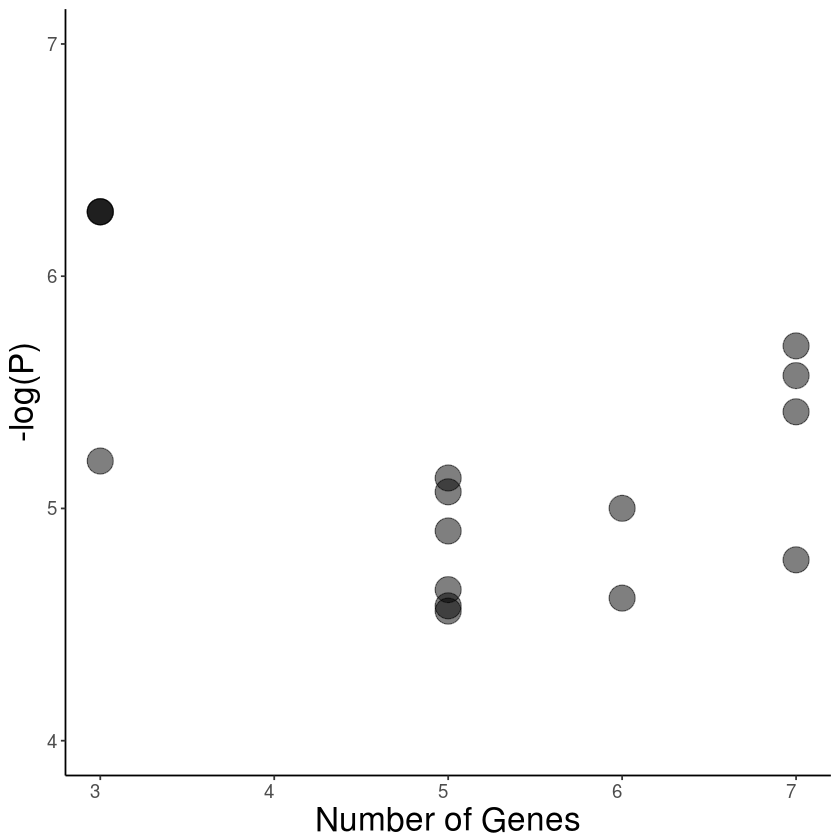

In [30]:
enr_file <- "species_diff_GO/altVindenrichment_results.txt"

enrichments <- read_delim(enr_file,"\t", escape_double = FALSE, col_names = TRUE, trim_ws = TRUE)
enrichments$logp <- log(enrichments$PValue,base=10)
ggplot(enrichments[enrichments$FDR < 0.05,],aes(x=O,y=-logp)) + geom_point(alpha=0.5,size=7) + theme_classic() + 
labs(x="Number of Genes",y="-log(P)") + theme(text = element_text(size=14),axis.title.x= element_text(size = 20),
                axis.text.x=element_text(vjust = 0.5, hjust=1),axis.title.y=element_text(size = 20))+ylim(4,7)
ggsave('GO_plot.pdf', width=6, height= 4) 

In [8]:
enrichments[enrichments$FDR < 0.1,]

geneset,description,link,C,O,E,R,PValue,FDR,overlapGene,OverlapGene_UserID,logp
umls:C0033578,Prostatic Neoplasms,http://www.disgenet.org/web/DisGeNET/menu/umls:C0033578,57,39,25.862302,1.507986,0.000246151,0.04356878,1012;10207;10397;10417;10451;11005;11187;150084;1509;1636;1775;207;2272;23635;2886;3091;3169;3292;3490;3728;373156;3732;3915;4023;4507;4585;463;472;4883;51655;54790;55829;6293;6462;6817;7079;7164;7421;8000,ENSG00000140945;ENSG00000132849;ENSG00000104419;ENSG00000159674;ENSG00000134215;ENSG00000133710;ENSG00000184363;ENSG00000183067;ENSG00000117984;ENSG00000159640;ENSG00000167968;ENSG00000142208;ENSG00000189283;ENSG00000145687;ENSG00000141738;ENSG00000100644;ENSG00000129514;ENSG00000108786;ENSG00000163453;ENSG00000173801;ENSG00000197448;ENSG00000085117;ENSG00000135862;ENSG00000175445;ENSG00000099810;ENSG00000145113;ENSG00000140836;ENSG00000149311;ENSG00000113389;ENSG00000108551;ENSG00000168769;ENSG00000131871;ENSG00000223501;ENSG00000129214;ENSG00000196502;ENSG00000157150;ENSG00000111907;ENSG00000111424;ENSG00000167653,-3.608798
umls:C0027051,Myocardial Infarction,http://www.disgenet.org/web/DisGeNET/menu/umls:C0027051,13,12,5.898420,2.034443,0.000531378,0.04702695,1636;1952;2056;2147;2730;3816;3957;4049;4313;472;5581;7056,ENSG00000159640;ENSG00000143126;ENSG00000130427;ENSG00000180210;ENSG00000023909;ENSG00000167748;ENSG00000100079;ENSG00000226979;ENSG00000087245;ENSG00000149311;ENSG00000171132;ENSG00000178726,-3.274596
umls:C0021368,Inflammation,http://www.disgenet.org/web/DisGeNET/menu/umls:C0021368,12,11,5.444695,2.020315,0.001101928,0.06118803,10544;2056;207;2588;3146;3552;3620;4313;4982;55829;623,ENSG00000101000;ENSG00000130427;ENSG00000142208;ENSG00000141012;ENSG00000189403;ENSG00000115008;ENSG00000131203;ENSG00000087245;ENSG00000164761;ENSG00000131871;ENSG00000100739,-2.957847
umls:C0025202,melanoma,http://www.disgenet.org/web/DisGeNET/menu/umls:C0025202,20,16,9.074492,1.763184,0.001533527,0.06118803,10397;10743;2056;23512;3371;4507;472;5443;54663;54790;55862;57700;5909;6850;80723;83638,ENSG00000104419;ENSG00000108557;ENSG00000130427;ENSG00000178691;ENSG00000041982;ENSG00000099810;ENSG00000149311;ENSG00000115138;ENSG00000133316;ENSG00000168769;ENSG00000093144;ENSG00000151553;ENSG00000076864;ENSG00000165025;ENSG00000168917;ENSG00000175573,-2.814309
umls:C0006663,Calcinosis,http://www.disgenet.org/web/DisGeNET/menu/umls:C0006663,8,8,3.629797,2.203980,0.001728475,0.06118803,2056;2209;249;29108;4313;5155;5443;80781,ENSG00000130427;ENSG00000150337;ENSG00000162551;ENSG00000103490;ENSG00000087245;ENSG00000100311;ENSG00000115138;ENSG00000182871,-2.762337


Parsed with column specification:
cols(
  geneset = col_character(),
  description = col_character(),
  link = col_character(),
  C = col_integer(),
  O = col_integer(),
  E = col_double(),
  R = col_double(),
  PValue = col_double(),
  FDR = col_double(),
  overlapGene = col_character(),
  OverlapGene_UserID = col_character()
)


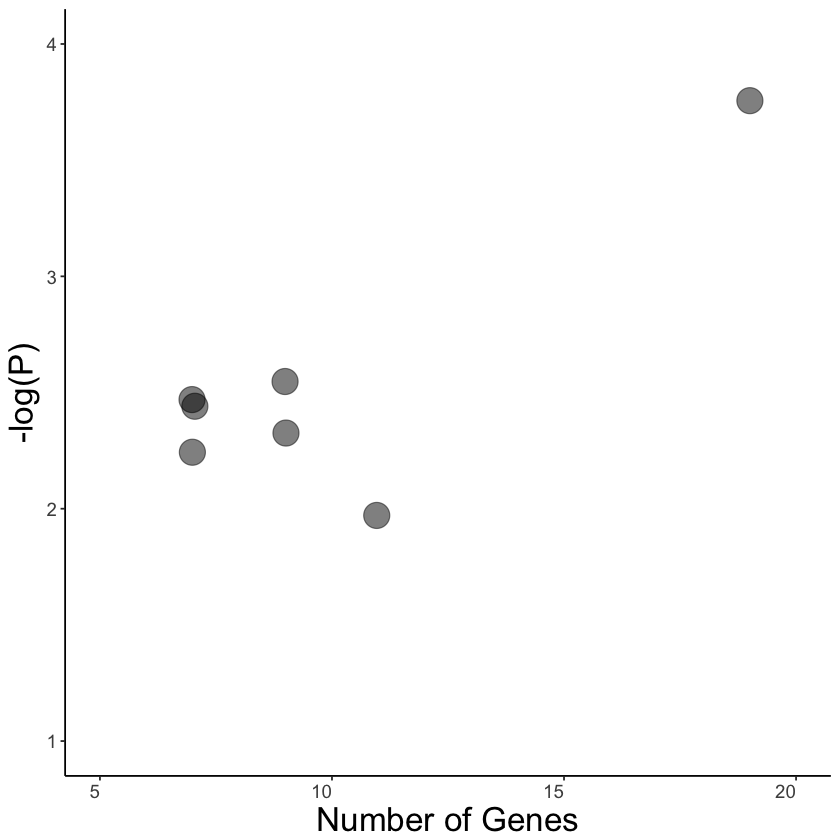

In [14]:
enr_file <- "../data/altai_disgenet.txt"

enrichments <- read_delim(enr_file,"\t", escape_double = FALSE, col_names = TRUE, trim_ws = TRUE)
enrichments$logp <- log(enrichments$PValue,base=10)
ggplot(enrichments[enrichments$FDR < 0.1,],aes(x=O,y=-logp)) + geom_jitter(alpha=0.5,size=7, width=0.05) + theme_classic() + 
labs(x="Number of Genes",y="-log(P)") + theme(text = element_text(size=14),axis.title.x= element_text(size = 20),
                axis.text.x=element_text(vjust = 0.5, hjust=1),axis.title.y=element_text(size = 20))+ylim(1,4)+xlim(5,20)
ggsave('../disgenet_plot.pdf', width=6, height= 4) 

In [17]:
t <- enrichments[enrichments$FDR < 0.1,]
kable(t[c(2,8,9,12)])



|description               |    PValue|       FDR|      logp|
|:-------------------------|---------:|---------:|---------:|
|Mammary Neoplasms         | 0.0001901| 0.0106471| -3.720956|
|Polycystic Ovary Syndrome | 0.0029703| 0.0509296| -2.527194|
|Spontaneous abortion      | 0.0036378| 0.0509296| -2.439157|
|Myocardial Infarction     | 0.0036378| 0.0509296| -2.439157|
|melanoma                  | 0.0045711| 0.0511965| -2.339978|
|Neoplasm Invasiveness     | 0.0061791| 0.0576719| -2.209072|
|Stomach Neoplasms         | 0.0111828| 0.0894624| -1.951450|

***
[Contents](#Contents)

<a id='gwarrplot'></a>
#### Plot DR GWARRs on chromosomes

pdf 
  3

pdf 
  2

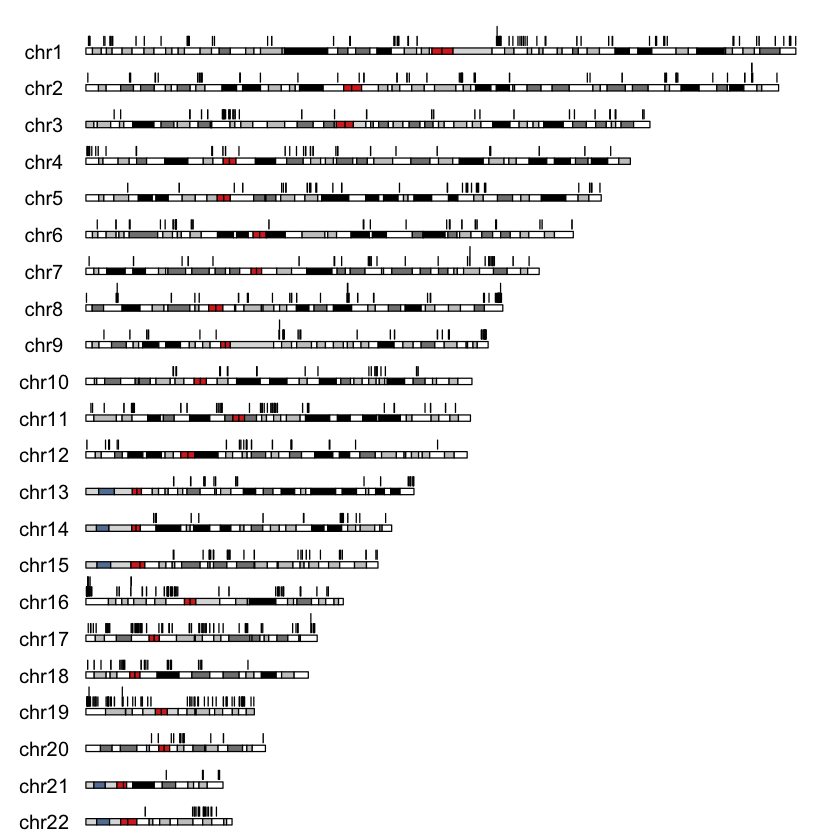

In [18]:
gene_file <- "~/Dropbox (VU Basic Sciences)/predixcan/altai_temp/dr_gwarrs_LDexpand.bed"

dr_genes <- read.delim(gene_file, header=FALSE, stringsAsFactors=FALSE)
for (i in 1:nrow(dr_genes)){
    dr_genes$V1[i] <- paste("chr",dr_genes$V1[i],sep="")
}

genes <- makeGRangesFromDataFrame(data_frame(chr = dr_genes$V1, start=dr_genes$V2,end=dr_genes$V3))

kp <-plotKaryotype(genome="hg19",chromosomes=c("chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18","chr19","chr20","chr21","chr22"))
kpPlotRegions(kp, data=genes,r1=0.75)
dev.copy(pdf,"../gwarrs.pdf",width = 6, height = 6)
dev.off()

***
[Contents](#Contents)

<a id='desertplot'></a>
#### Plot Desert Genes on chromosomes

pdf 
  3

pdf 
  2

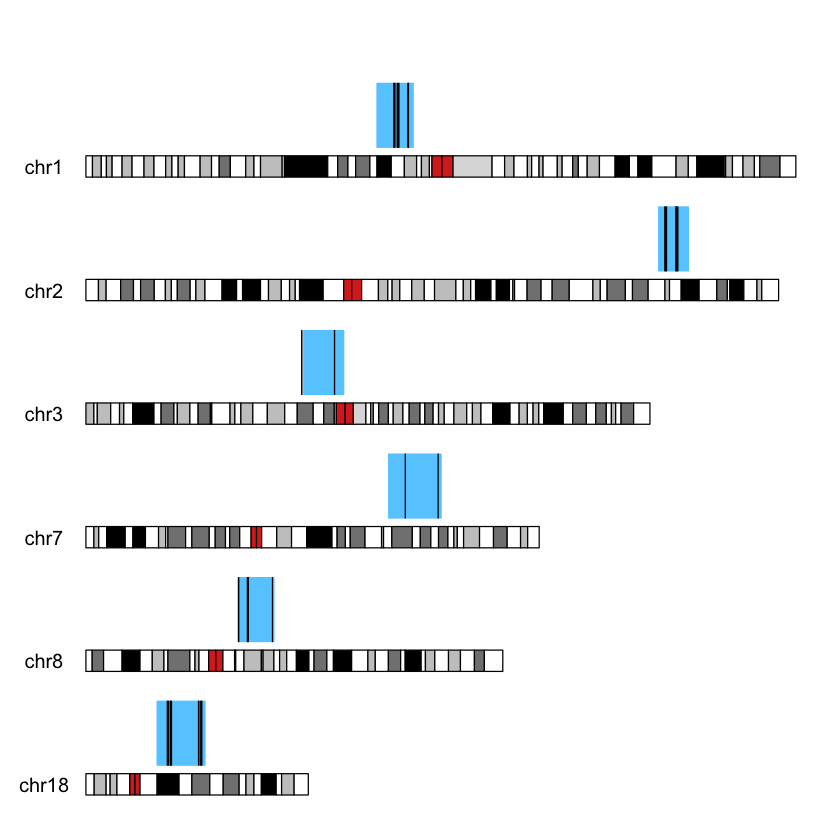

In [8]:
gene_file <- "~/Dropbox (VU Basic Sciences)/predixcan/altai_temp/dr_desert_genes_LDexpand.bed"
deserts <- "~/Dropbox (VU Basic Sciences)/predixcan/data/nean_deserts.bed"

dr_genes <- read.delim(gene_file, header=FALSE, stringsAsFactors=FALSE)
des <- read.delim(deserts, header=FALSE, stringsAsFactors=FALSE,comment.char = "#")
for (i in 1:nrow(dr_genes)){
    dr_genes$V1[i] <- paste("chr",dr_genes$V1[i],sep="")
}
for (i in 1:nrow(des)){
    des$V1[i] <- paste("chr",des$V1[i],sep="")
}

#chrms <- unique(dr_genes$V1))
chrms <- c("chr1","chr2","chr3","chr7","chr8","chr18")
genes <- makeGRangesFromDataFrame(data_frame(chr = dr_genes$V1, start=dr_genes$V2,end=dr_genes$V3))
deserts <- makeGRangesFromDataFrame(data_frame(chr = des$V1, start=des$V2,end=des$V3))
#values(genes) <- DataFrame(names=c("ZDBF2","PIK3C3","VAV3","RB1CC1","CHMP2B","PSRC1","GAREM1","RIT2","STXBP3","BMPR2","ZNF717","THAP5","ADAM23","CELSR2","DSG3","TGS1","SYPL1","ST7L","TMEM229A","CPO","MOV10","CARF","LSMEM1","BHLHE22","MOS","RNF138","DSC3"))

kp <-plotKaryotype(genome="hg19", chromosomes=chrms)
kpPlotRegions(kp, deserts, col="#66ccff",r1=0.75)
kpPlotRegions(kp, data=genes,r1=0.75)
dev.copy(pdf,"../desert_genes.pdf",width = 10, height = 3)
dev.off()

***
[Contents](#Contents)

<a id='1kgdist'></a>
#### plot greyscale 1kG distribution of a gene

HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,HG00103,HG00105,HG00106,HG00107,⋯,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
-0.1158433,0.302823,0.3757591,0.08553885,0.2056745,0.188417,0.01127621,-0.1108257,-0.2011438,0.2519836,⋯,0.03646282,0.3422601,-0.06431296,0.2118796,-0.03859374,-0.003597486,0.1266167,-0.1021731,0.03283709,-0.03481613


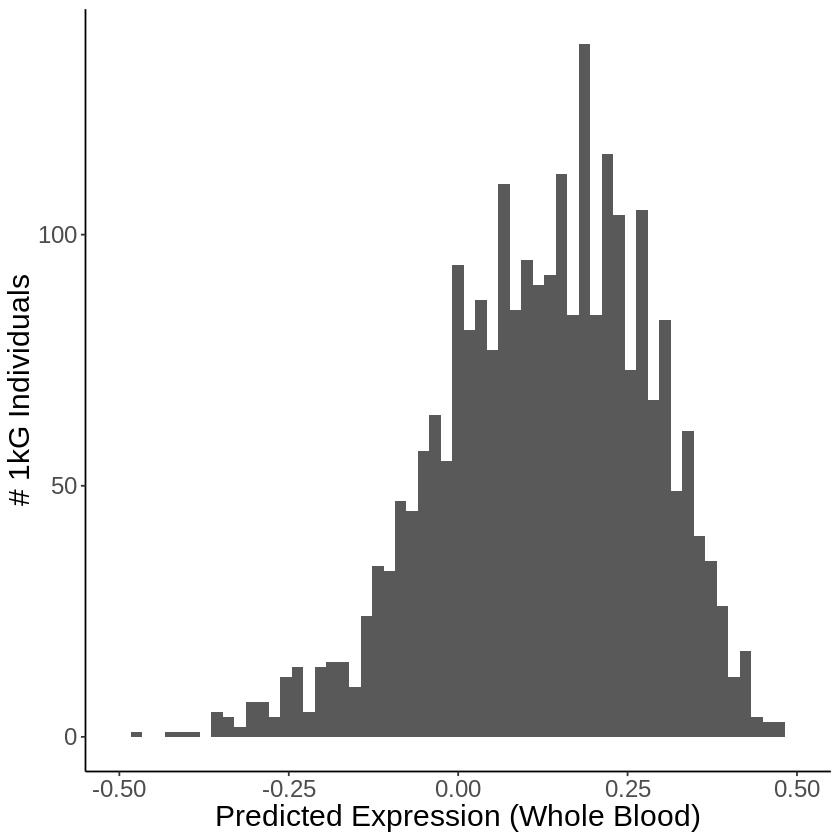

In [35]:
dist_path <- "~/Dropbox (VU Basic Sciences)/predixcan/results/exp_dist_1kG/vdr_wholeblood.txt"
#dist_path <- "../cyp11a1_adiposeVO_dist.txt"

dist <- read.delim(dist_path,header =T, comment.char = '#')
dist$gene <- NULL
dist
dist <- as.data.frame(t(dist))

ggplot(dist,aes(V1)) + geom_histogram(bins = 60) + xlab("Predicted Expression (Whole Blood)") + ylab("# 1kG Individuals") + theme_classic() +
  theme(text = element_text(size=18),axis.title.x= element_text(size = 18),axis.title.y=element_text(size = 18)) +xlim(-0.5,0.5)
ggsave("../vdr_wb.pdf",width=5, height=4)

Joining, by = "X.Individual.ID"
Warning message:
“Column `X.Individual.ID` joining character vector and factor, coercing into character vector”

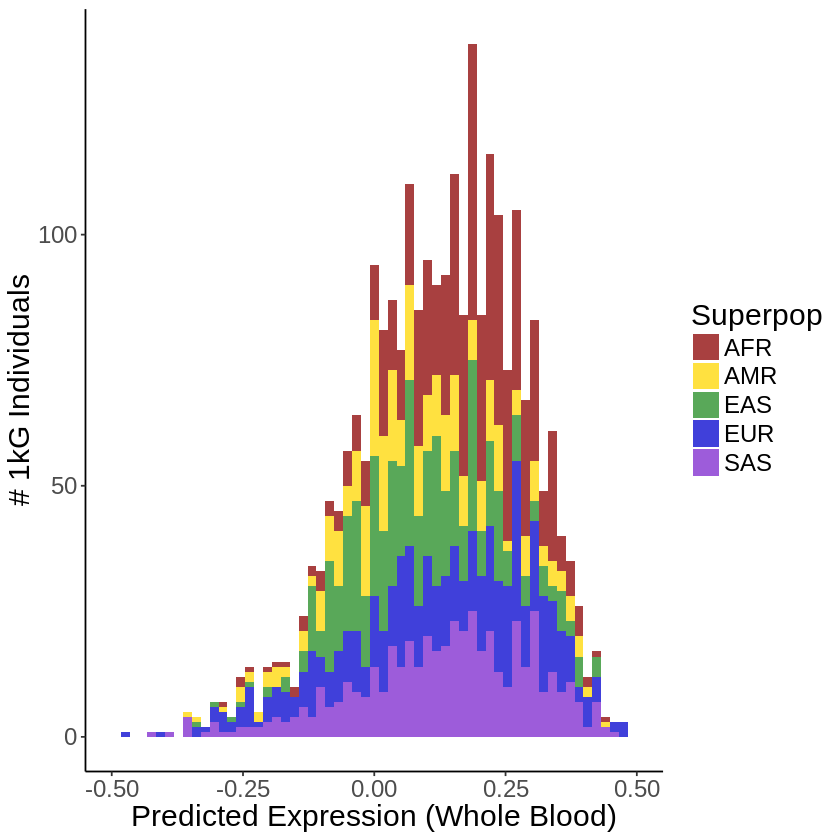

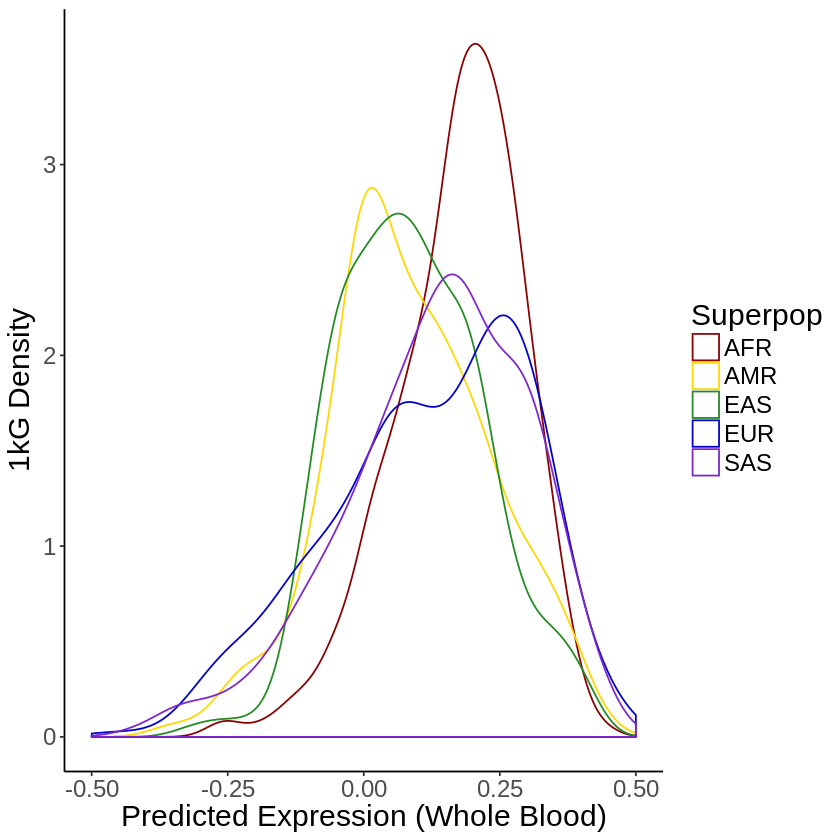

In [36]:
dist_path <- "~/Dropbox (VU Basic Sciences)/predixcan/results/exp_dist_1kG/vdr_wholeblood.txt"
id_path <- "~/Dropbox (VU Basic Sciences)/predixcan/data/1kG_SuperPop_IDs.txt"

dist <- read.delim(dist_path,header =T)
dist$gene<- NULL
dist <- tibble::rownames_to_column(as.data.frame(t(dist)), "X.Individual.ID")

pop_ids <- read.delim(id_path,header =T)
dist <- inner_join(dist,pop_ids)

ggplot(dist,aes(V1)) + geom_histogram(bins = 60,aes(fill=Superpop),alpha=0.75) + xlab("Predicted Expression (Whole Blood)") + ylab("# 1kG Individuals") +
  theme_classic() + scale_fill_manual(values=c("darkred","gold","forestgreen","mediumblue","purple3")) +
  theme(text = element_text(size=18),axis.title.x= element_text(size = 18),axis.title.y=element_text(size = 18)) +xlim(-0.5,0.5)
ggsave("../vdr_wb_pops_stacked.pdf",width=5, height=4)
#ggplot(dist,aes(V1)) + geom_histogram(bins = 60,aes(fill=Superpop),alpha=0.5,position = 'identity') + xlab("Predicted Expression (Tibial Artery)") + ylab("# 1kG Individuals") +
#  theme_classic() + scale_fill_manual(values=c("darkred","gold","forestgreen","mediumblue","purple3")) +
#  theme(text = element_text(size=18),axis.title.x= element_text(size = 18),axis.title.y=element_text(size = 18)) +xlim(-0.5,0.5)
#ggsave("dist_wholeblood_pops_overlap.pdf",width=5, height=4)
ggplot(dist) +
  geom_density(aes(x=V1,colour=Superpop)) + xlab("Predicted Expression (Whole Blood)") + ylab("1kG Density") +
  theme_classic() + scale_colour_manual(values=c("darkred","gold","forestgreen","mediumblue","purple3")) +
  theme(text = element_text(size=18),axis.title.x= element_text(size = 18),axis.title.y=element_text(size = 18)) +xlim(-0.5,0.5)
ggsave("../vdr_wb_pops_density.pdf",width=5, height=4)

***
[Contents](#Contents)

<a id='bias'></a>
### Direction Bias

In [4]:
  pvals <- read.delim("~/Dropbox (VU Basic Sciences)/predixcan/altai_temp/altai_1kG_fixed_p_values_2sided_tissues_top_genes.txt", 
                      sep="\t", header=F)
  expression <- read_delim("~/Dropbox (VU Basic Sciences)/predixcan/altai_temp/altai_1kG_fixed.txt", 
                           "\t", escape_double = FALSE, trim_ws = TRUE)
  intro_path <- "../data/altai_intro_genes.txt"
  intro <- read_csv(intro_path, col_names = FALSE)
  intro$gene_id <- intro$X1
  intro$X1 <- NULL

  tissues <- unique(pvals$V1)
  pvals$gene_id <- pvals$V3
  pvals$V3 <- NULL
  expP <- 0
  t <- 0
  for (i in 1:length(tissues)){
    expP <- expP + nrow(expression[expression[,i+1] > 0 & !is.na(expression[,i+1]),]) #count overall up
    t <- t + nrow(expression[!is.na(expression[,i+1]),]) #count total
  }
  expP <- expP/t
  print("Overall Prop Up: ")
  print(expP)

Parsed with column specification:
cols(
  .default = col_double(),
  gene_id = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "Overall Prop Up: "
[1] 0.4347225


In [6]:
  c_up <- c()
  c_down <- c()
  p <- c()
  for (i in 1:length(tissues)) {
    vals <- anti_join(inner_join(pvals[pvals$V1 == tissues[i],],expression),intro)[i+3] #pull DR expr per tissue
    c_up <- c(c_up,length(vals[vals > 0]))
    c_down <- c(c_down,length(vals[vals < 0]))
    if (c_up[i]+c_down[i] > 0){p <- c(p,binom.test(c_up[i],c_up[i]+c_down[i],p = expP)$p.value)}
    else{p <- c(p,NA)}    
  }
  bias <- data.frame(tissues = tissues, prop_up = c_up/(c_up + c_down), p = p)

Joining, by = "gene_id"
Warning message:
“Column `gene_id` joining factor and character vector, coercing into character vector”Joining, by = "gene_id"
Joining, by = "gene_id"
Warning message:
“Column `gene_id` joining factor and character vector, coercing into character vector”Joining, by = "gene_id"
Joining, by = "gene_id"
Warning message:
“Column `gene_id` joining factor and character vector, coercing into character vector”Joining, by = "gene_id"
Joining, by = "gene_id"
Warning message:
“Column `gene_id` joining factor and character vector, coercing into character vector”Joining, by = "gene_id"
Joining, by = "gene_id"
Warning message:
“Column `gene_id` joining factor and character vector, coercing into character vector”Joining, by = "gene_id"
Joining, by = "gene_id"
Warning message:
“Column `gene_id` joining factor and character vector, coercing into character vector”Joining, by = "gene_id"
Joining, by = "gene_id"
Warning message:
“Column `gene_id` joining factor and character vector

In [7]:
bias

tissues,prop_up,p
adipose_subcutaneous,0.4347826,1.00000000
esophagus_mucosa,0.3939394,0.72678889
adipose_visceral_omentum,0.5625000,0.32326725
esophagus_muscularis,0.6666667,0.01886372
adrenal_gland,0.3500000,0.50520505
heart_atrial_appendage,0.4736842,0.81845093
anterior_cingulate_cortex,0.6000000,0.34765071
left_ventricle,0.5000000,0.63822036
artery_aorta,0.2941176,0.32932374
liver,0.6000000,0.20556309


***
[Contents](#Contents)

<a id='neancorr'></a>
#### predicted expression correlations between Altai genomes

In [49]:
original_path <- "data/altai_original_predExp.txt"
update_path <- "data/altai_update_predExp.txt"
excl1_path <- "data/altai_original_missingModels.txt"
excl2_path <- "data/altai_update_missingModels.txt"

orig_mat <- read_delim(original_path, "\t", escape_double = FALSE, trim_ws = TRUE)
upd_mat <- read_delim(update_path, "\t", escape_double = FALSE, trim_ws = TRUE)
excl1 <- read_delim(excl1_path,"\t", escape_double = FALSE, col_names = FALSE, trim_ws = TRUE)
excl2 <- read_delim(excl2_path,"\t", escape_double = FALSE, col_names = FALSE, trim_ws = TRUE)

excl1$gene_id <- excl1$X1
excl1$X1 <- NULL
excl2$gene_id <- excl2$X1
excl2$X1 <- NULL

orig_mat <- anti_join(anti_join(orig_mat,excl1),excl2)
upd_mat <- anti_join(anti_join(upd_mat,excl1),excl2)
out <- DataFrame(tissue = rep("nil",ncol(orig_mat)-1))
for (i in 2:ncol(orig_mat)) {
    out$tissue[i-1] <- names(orig_mat)[i]
    out$rho[i-1] <- cor.test(orig_mat[,i][[1]],upd_mat[,i][[1]],method = "spearman")$estimate
    out$p[i-1] <- cor.test(orig_mat[,i][[1]],upd_mat[,i][[1]],method = "spearman")$p.value
}
mean(out$rho)
kable(out)

Parsed with column specification:
cols(
  .default = col_double(),
  gene_id = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  gene_id = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  X1 = col_character()
)
Parsed with column specification:
cols(
  X1 = col_character()
)
Joining, by = "gene_id"
Joining, by = "gene_id"
Joining, by = "gene_id"
Joining, by = "gene_id"
Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], me

"Cannot compute exact p-value with ties"Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], method = "spearman"):
"Cannot compute exact p-value with ties"W

[1] 0.8117608



|tissue                                |       rho|  p|
|:-------------------------------------|---------:|--:|
|adipose_subcutaneous                  | 0.8354703|  0|
|esophagus_mucosa                      | 0.8324968|  0|
|adipose_visceral_omentum              | 0.8248803|  0|
|esophagus_muscularis                  | 0.8284796|  0|
|adrenal_gland                         | 0.8113760|  0|
|heart_atrial_appendage                | 0.8045131|  0|
|anterior_cingulate_cortex             | 0.7928536|  0|
|left_ventricle                        | 0.8110262|  0|
|artery_aorta                          | 0.8216417|  0|
|liver                                 | 0.7944327|  0|
|artery_coronary                       | 0.7950425|  0|
|lung                                  | 0.8267054|  0|
|artery_tibial                         | 0.8352358|  0|
|muscle_skeletal                       | 0.8300338|  0|
|brain_caudate_basal_ganglia           | 0.7862996|  0|
|nerve_tibial                          | 0.848

***
[Contents](#Contents)

<a id='tisscorr'></a>
#### correlation between tissue sample size and DR genes

Joining, by = "V1"
Warning message:
“Column `V1` joining factors with different levels, coercing to character vector”Warning message in cor.test.default(dr_genes$count, dr_genes$V2, method = "spearman"):
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  dr_genes$count and dr_genes$V2
S = 1447.8, p-value = 1.272e-15
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8906811 


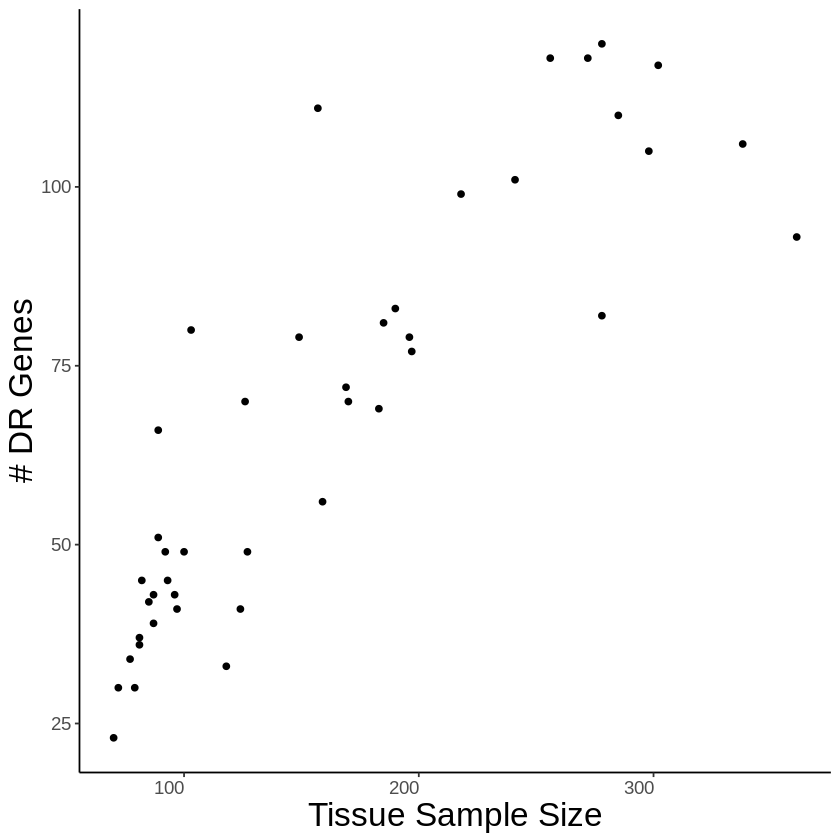

In [3]:
size_path <- "~/Dropbox (VU Basic Sciences)/predixcan/data/gtex_v6_sample_sizes.txt"
dr_path <- "~/Dropbox (VU Basic Sciences)/predixcan/results/altai_1kG_fixed/altai_1kG_fixed_p_values_2sided_tissues_top_genes.txt"

dr_genes <- read.delim(dr_path,header =F)
sample_size <- read.delim(size_path,header=F)

dr_genes$iter <- 1
dr_genes <- dr_genes %>% group_by(V1) %>% summarise(count = sum(iter))
dr_genes <- inner_join(dr_genes,sample_size)

cor.test(dr_genes$count,dr_genes$V2,method = "spearman")

ggplot(dr_genes,aes(x=V2,y=count)) + geom_point() + theme_classic() + 
labs(x="Tissue Sample Size",y="# DR Genes") + theme(text = element_text(size=14),axis.title.x= element_text(size = 20),
                axis.text.x=element_text(vjust = 0.5, hjust=1),axis.title.y=element_text(size = 20))
ggsave('sampleSize_drCount.pdf', width=6, height= 4) 

***
[Contents](#Contents)